##Program 3

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - kl_loss: 6.4123 - loss: 345.7755 - reconstruction_loss: 339.3633 - val_kl_loss: 5.9570 - val_loss: 281.1161 - val_reconstruction_loss: 275.1591
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 5.9675 - loss: 278.2293 - reconstruction_loss: 272.2619 - val_kl_loss: 6.1873 - val_loss: 273.4275 - val_reconstruction_loss: 267.2402
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 6.0635 - loss: 270.8906 - reconstruction_loss: 264.8271 - val_kl_loss: 6.1874 - val_loss: 268.8203 - val_reconstruction_loss: 262.6329
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 6.1529 - loss: 267.3026 - reconstruction_loss: 261.1497 - val_kl_loss: 6.0008 - val_loss: 266.3831 - val_reconstruction_loss: 260.3824
Epoch 5/30
469/469

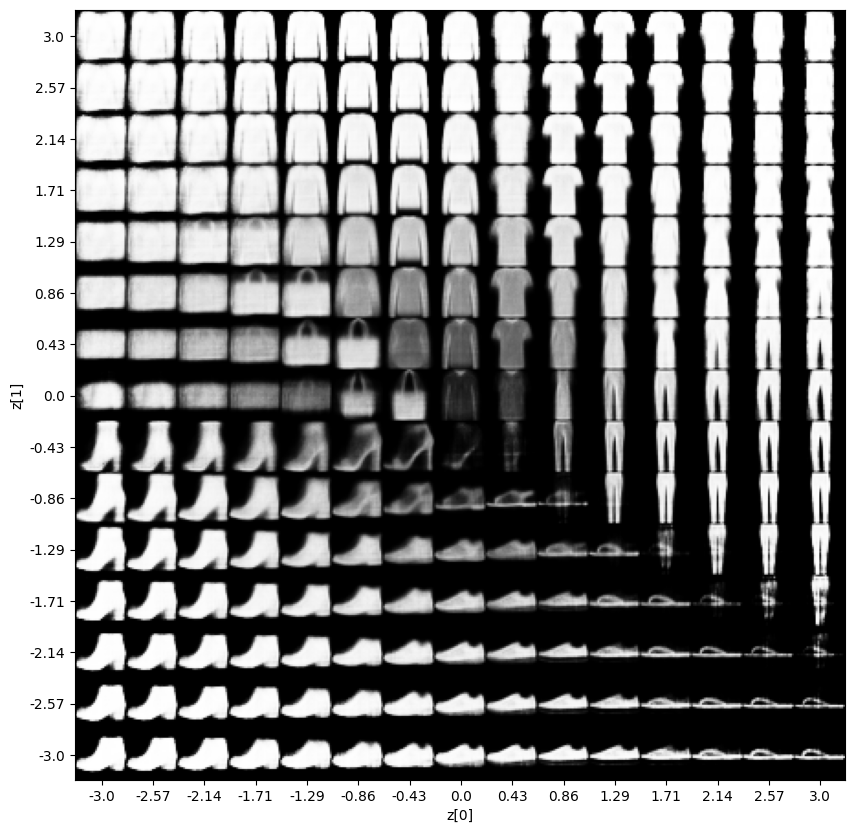

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


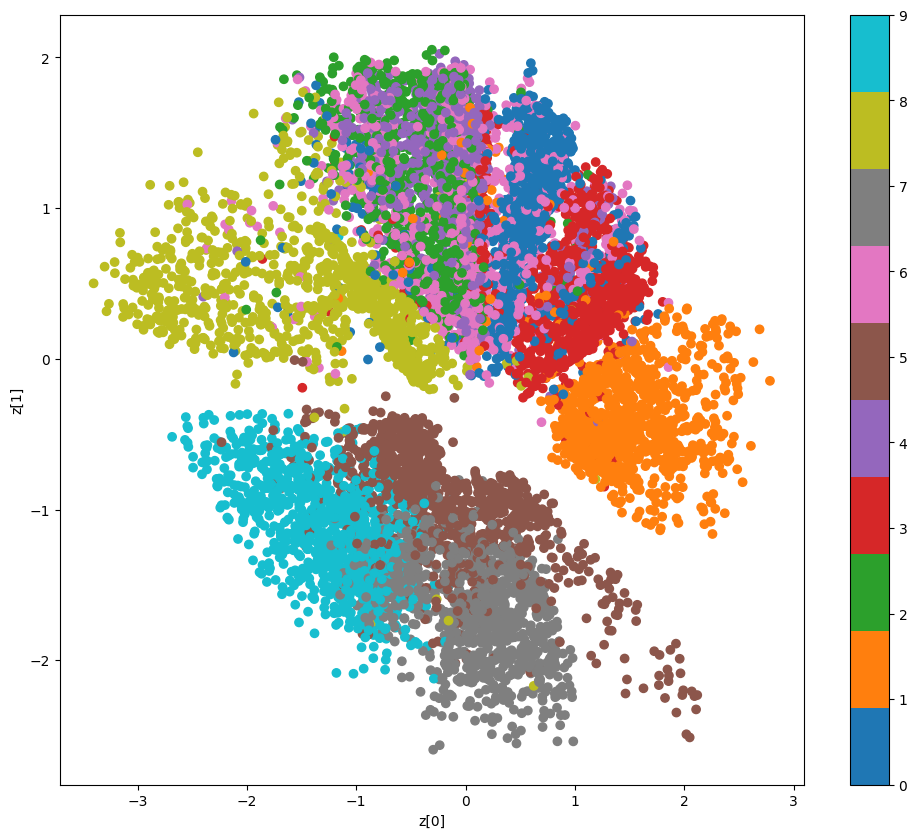

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize and flatten the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((-1, 28 * 28))
x_test = x_test.reshape((-1, 28 * 28))

# Define the Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Build the Encoder
latent_dim = 2

encoder_inputs = keras.Input(shape=(784,))
x = layers.Dense(256, activation='relu')(encoder_inputs)
x = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Build the Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(256, activation='relu')(x)
decoder_outputs = layers.Dense(784, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Define the VAE Model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        # Return all outputs for potential use in inference
        return reconstruction, z_mean, z_log_var, z

    def train_step(self, data):
        inputs, _ = data  # Ignore targets since they are same as inputs
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(inputs)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(inputs, reconstruction)
            )
            reconstruction_loss *= 784  # Scale by image dimensions
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        inputs, _ = data
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            keras.losses.binary_crossentropy(inputs, reconstruction)
        )
        reconstruction_loss *= 784  # Scale by image dimensions
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

# Train the VAE
vae.fit(x_train, x_train, epochs=30, batch_size=128, validation_data=(x_test, x_test))

# Generate New Images
n = 15  # Grid size
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = (n - 1) * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
plt.xticks(pixel_range, np.round(grid_x, 2))
plt.yticks(pixel_range, np.round(grid_y, 2))
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')
plt.savefig('vae_generated_images.png')  # Save the figure
plt.show()

# Visualize the Latent Space
z_mean, _, _ = encoder.predict(x_test)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='tab10')
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.savefig('vae_latent_space.png')  # Save the figure
plt.show()